<a href="https://colab.research.google.com/github/S413/KerasExamples/blob/main/BostonHousingPriceRegressionEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
type(train_data)

numpy.ndarray

In [5]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [6]:
train_targets[0]

15.2

In [7]:
train_targets.shape

(404,)

It would be a problem to feed the NN the data as is because everything has different scales. Let's to feature-wise normalization, otherwise known to me as standarization. Subtract the mean and divide by the standard deviation for each feature of the input matrix.

In [8]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

The author used the mean and std of the training set on the test set. He asserts that we should never obtain values from test set. That's surprising to me.

In [9]:
from keras import models
from keras import layers

In [10]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
  model.add(layers.Dense(64, activation='relu'))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

This time around our data points are few. Validation set would be too small and the results would vary too greatly depending on the validation set's variance. What we can do in this instance is use K-fold Validation.

1. Divide the training set into K partitions (usually 4 or 5).
2. Instantiate K models.
3. Each model trains on K-1 partitions and evaluates on the remaining partition
4. Validation score = avg of all K validation scores

In [11]:
import numpy as np

In [12]:
k = 4
num_vals_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [13]:
for i in range (k):
  print('Processing fold {}\n'.format(i))
  val_data = train_data[i * num_vals_samples: (i + 1) * num_vals_samples]
  val_targets = train_targets[i * num_vals_samples: (i + 1) * num_vals_samples]

  partial_train_data = np.concatenate([train_data[:i * num_vals_samples], train_data[(i + 1) * num_vals_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_vals_samples], train_targets[(i + 1) * num_vals_samples:]], axis = 0)

  model = build_model()

  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

Processing fold 0

Processing fold 1

Processing fold 2

Processing fold 3



In [14]:
all_scores

[1.8758890628814697, 2.409372091293335, 2.499647378921509, 2.5309009552001953]

In [15]:
np.mean(all_scores)

2.328952372074127

In [16]:
num_vals_samples

101

Let's try with more epochs.

In [17]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('Processing fold {}\n'.format(i))
  
  val_data = train_data[i * num_vals_samples: (i + 1) * num_vals_samples]
  val_targets = train_targets[i * num_vals_samples : (i + 1) * num_vals_samples]

  partial_train_data = np.concatenate([train_data[: i * num_vals_samples], train_data[(i + 1) * num_vals_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[: i * num_vals_samples], train_targets[(i + 1) * num_vals_samples:]], axis=0)

  model2 = build_model()

  history = model2.fit(partial_train_data, partial_train_targets, epochs=num_epochs, validation_data=(val_data, val_targets), batch_size=1, verbose=0)

  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)


Processing fold 0

Processing fold 1

Processing fold 2

Processing fold 3



In [18]:
len(all_mae_histories[0])

500

In [19]:
avg_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range (num_epochs)]

In [20]:
len(avg_mae_history)

500

In [21]:
import matplotlib.pyplot as plt

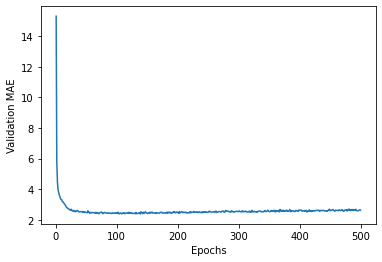

In [22]:
plt.plot(range(1, len(avg_mae_history) + 1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Pretty much unreadable. Let's:
1. Omit first 10 data points
2. Replace each point with an exponential moving average of the previous points to obtain a smooth curve (what?)

In [23]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []

  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  
  return smoothed_points

In [24]:
smooth_mae_history = smooth_curve(avg_mae_history[10:])

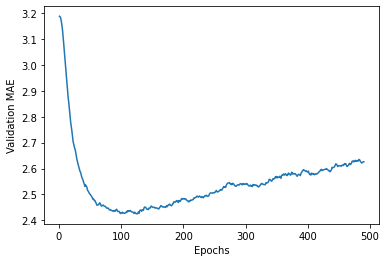

In [25]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [30]:
model3 = build_model()

model3.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model3.evaluate(test_data, test_targets) 

4/4 [==============================] - 0s 2ms/step - loss: 20.6719 - mae: 2.8840


In [31]:
test_mae_score

2.884040117263794